In [156]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
model = EfficientNetB0(include_top=False, weights='imagenet')
import matplotlib.pyplot as plt

In [157]:
dataset = tf.keras.utils.image_dataset_from_directory("C:/class/sql/BATT/")

Found 55 files belonging to 3 classes.


In [99]:
pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [158]:
import tensorflow_datasets as tfds
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import keras

In [172]:
image, label = next(iter(dataset))

In [174]:
label = tf.keras.utils.to_categorical(label, 3)

In [175]:
label

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [162]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=15, zoom_range=0.2, brightness_range=[0.5,1.5],validation_split=0.1)
it = datagen.flow(image, label,subset="training")
it_v = datagen.flow(image, label,subset="validation")

In [163]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [164]:
def build_model(num_classes):
    inputs = layers.Input(shape=(256, 256, 3))
    # x = img_augmentation(inputs)
    model = EfficientNetV2S(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(3, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [165]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

82436096/82420632 [==============================] - 3s 0us/step


<ipython-input-166-537fcea759dd>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(it,epochs=epochs,validation_data=it_v)


Epoch 1/20
1/1 [==============================] - 11s 11s/step - loss: 1.9299 - accuracy: 0.3448 - val_loss: 0.6587 - val_accuracy: 0.6667
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.1341 - accuracy: 0.9655 - val_loss: 0.3204 - val_accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.0764 - accuracy: 0.9655 - val_loss: 0.0928 - val_accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.0306 - accuracy: 0.9655 - val_loss: 0.1014 - val_accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.0891 - accuracy: 0.9310 - val_loss: 0.0820 - val_accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 0.0346 - accuracy: 0.9655 - val_loss: 0.0466 - val_accuracy: 1.0000
Epoch 8/20
1/1 [=======================

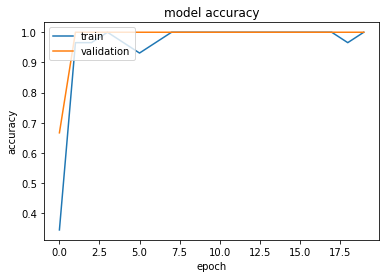

In [166]:
with strategy.scope():
    model = build_model(num_classes=3)

epochs = 20  # @param {type: "slider", min:8, max:80}
hist = model.fit_generator(it,epochs=epochs,validation_data=it_v)
plot_hist(hist)

In [167]:
model.save("./batt.h5")

In [176]:
from PIL import Image
img = Image.open("C:/class/sql/BATT/button/7.jpg")
#img.show()
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.image.resize(img,[256,256])
img = tf.expand_dims(img,axis=0)

In [177]:
import numpy as np
model.predict(img)[0]

array([0.00112785, 0.01090512, 0.9879671 ], dtype=float32)